# CNN

This notebook uses FastAI, a PyTorch-based deep learning library, to build the neural network, which is able to figure out the relationship between input features and find hidden relationship with them. The input data is an image dataset with labels, which is converted from time series with Gramian Angular Field algorithm as described in the previous sections.  

In [1]:
# import libraries and packages
import torch
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.tabular import *
import pandas as pd

In [10]:
import warnings
warnings.filterwarnings('ignore')

Make sure PyTorch version is compatible with Cuda 10.1.

In [2]:
torch.__version__

'1.7.1+cu101'

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.set_device(0)

### 1. Load Data
We first load Gramian Angular Field images and a csv file with labels to create a dataloader object.

In [5]:
gramian_df = pd.read_csv('../data/processed data/gramian_df.csv', index_col='date')

In [6]:
path = '../data/processed data'
df = pd.read_csv(path+'/label_dir_2.csv')
df = df[df.date.isin(list(gramian_df.index))]
df.date = df.date.apply(lambda x: x+'.png')
df.head()

,date,label
0,2017-01-02.png,0
1,2017-01-03.png,1
2,2017-01-04.png,0
3,2017-01-05.png,1
4,2017-01-06.png,0


In [7]:
df.groupby('label').date.count()

label
0    531
1    457
Name: date, dtype: int64

In [11]:
img_path = '../data/imgs'
data = ImageDataBunch.from_df(img_path, df, valid_pct=0.2, size=224)

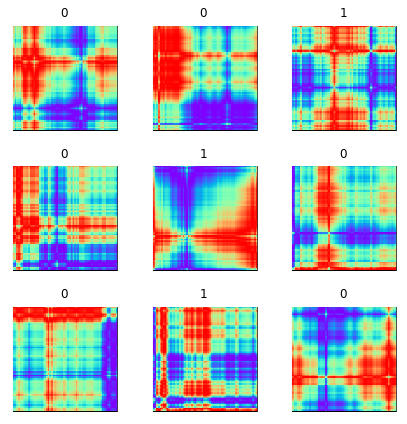

In [12]:
data.show_batch(rows=3, figsize=(6,6))

### 2. Base CNN (ResNet34 + Custom Head)

For the CNN network, the pretrained ResNET-34 is utilized as the bottom layers. We added [1024, 2] dense layers on top and a simple linear activation node for the final regression as a custom head. The figure below shows the architecture of the top layers of the model. For the loss function, our final model used cross-entropy loss. For the model metrics, we used accuracy. 

In [13]:
# Create custom_head
layers = [AdaptiveConcatPool2d(), Flatten(), nn.Linear(1024,2)]
head = nn.Sequential(*layers)

In [18]:
learner = cnn_learner(data, 
                      models.resnet34, 
                      pretrained=True,
                      custom_head=head,
                     metrics=[error_rate, accuracy]
                     ).to_fp16()
#learner = cnn_learner(data, models.resnet34, pretrained = True, custom_head=head, loss_func=mae, metrics=[r2_score]).to_fp16()
learner.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): Linear(in_features=1024, out_features=2, bias=True)
)

### 3. Improve the model

Now, with this baseline model, we first find the optimal learning rate for the initial layers, and then train the model with it for 10 epochs.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-03
Min loss divided by 10: 5.32E-04


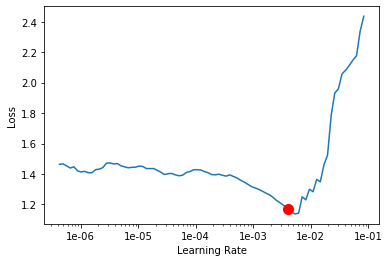

In [19]:
learner.lr_find(start_lr=1e-07,end_lr=0.2, num_it=100)
learner.recorder.plot(suggestion=True)

In [20]:
mingradlr = learner.recorder.min_grad_lr
print(mingradlr)

0.00397879805377195


In [21]:
lr = mingradlr
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.377303,1.720458,0.487310,0.512690,00:11
1,1.036478,1.656478,0.502538,0.497462,00:11
2,0.808037,1.348182,0.456853,0.543147,00:11
3,0.606633,1.328147,0.431472,0.568528,00:11
4,0.457613,1.295149,0.416244,0.583756,00:11
5,0.344236,1.263438,0.416244,0.583756,00:11
6,0.262568,1.262522,0.390863,0.609137,00:11
7,0.202249,1.341436,0.416244,0.583756,00:10
8,0.157020,1.320453,0.390863,0.609137,00:11
9,0.123232,1.321466,0.390863,0.609137,00:11


Next, we unfreeze the model and look for the optimal learning rate with all the layers. Using this, we now train all the layers for 10 epochs again.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.14E-05
Min loss divided by 10: 3.90E-05


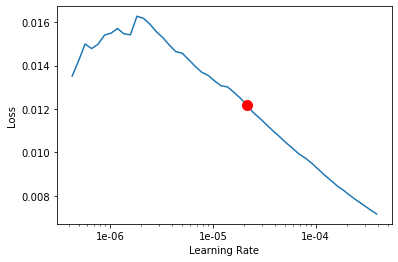

In [22]:
learner.unfreeze()
learner.lr_find(start_lr=1e-07,end_lr=0.2, num_it=100) 
learner.recorder.plot(suggestion=True)

In [23]:
mingradlr1 = learner.recorder.min_grad_lr
print(mingradlr1)

2.1447718375158533e-05


In [24]:
learner.fit_one_cycle(10, slice(mingradlr1, mingradlr1/20))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.014843,1.319504,0.390863,0.609137,00:12
1,0.013657,1.308300,0.406091,0.593909,00:11
2,0.011282,1.344853,0.385787,0.614213,00:11
3,0.009185,1.384175,0.401015,0.598985,00:12
4,0.007462,1.413593,0.390863,0.609137,00:12
5,0.006095,1.400707,0.390863,0.609137,00:12
6,0.004858,1.400769,0.385787,0.614213,00:12
7,0.004000,1.404500,0.385787,0.614213,00:11
8,0.003375,1.409730,0.385787,0.614213,00:12
9,0.002900,1.406817,0.385787,0.614213,00:11


If your first attempt does not produce a desired accuracy, consider running it again from the beginning to obtain a better model.

### 4. Results

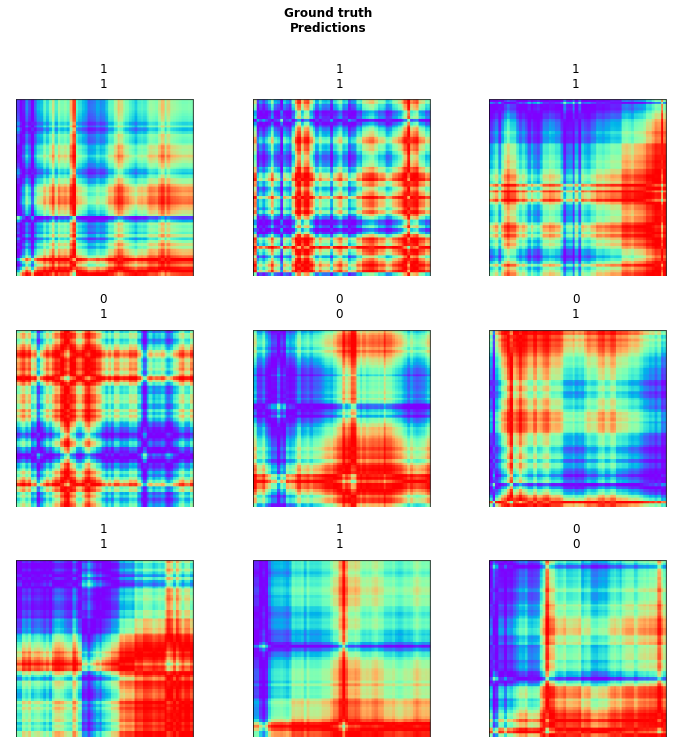

In [25]:
learner.show_results(rows=3)

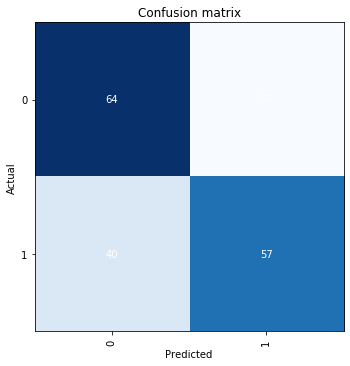

In [26]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(5,5))

In [27]:
learner.save('model_1')